# Import Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    KFold
)
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    fbeta_score, 
    roc_auc_score,
    classification_report,
    accuracy_score,
    make_scorer,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from tabulate import tabulate

from helpers import (
    data_preparation, 
    plot_helper, 
    my_imputer, 
    results_func
)
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 1. Data import

In [81]:
data_raw = pd.read_csv("Train_nyOWmfK.csv", encoding='unicode_escape')

In [82]:
pd.set_option('display.max_columns', None)

# 2. Exploratory Data Analysis

In [83]:
data_raw.head(3)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0


In [84]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     87020 non-null  object 
 1   Gender                 87020 non-null  object 
 2   City                   86017 non-null  object 
 3   Monthly_Income         87020 non-null  int64  
 4   DOB                    87020 non-null  object 
 5   Lead_Creation_Date     87020 non-null  object 
 6   Loan_Amount_Applied    86949 non-null  float64
 7   Loan_Tenure_Applied    86949 non-null  float64
 8   Existing_EMI           86949 non-null  float64
 9   Employer_Name          86949 non-null  object 
 10  Salary_Account         75256 non-null  object 
 11  Mobile_Verified        87020 non-null  object 
 12  Var5                   87020 non-null  int64  
 13  Var1                   87020 non-null  object 
 14  Loan_Amount_Submitted  52407 non-null  float64
 15  Lo

**2.1 looking for NaN values**

In [85]:
na_column_list = [col for col in data_raw.columns if data_raw[col].isna().sum()> 0]

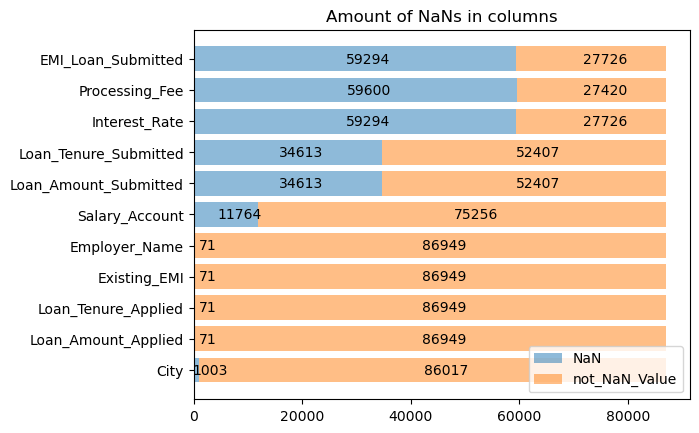

In [86]:
plotter = plot_helper.NanPlotter(na_column_list)
plotter.bar_chart_plotter(data_raw)

**conclusion** 

In 11  of 26 columns NaN values are present. Especially missing values constitute a large percentage of all values in columns 

EMI_Loan_Submitted, 

Processing_Fee, 

Interest_Rate, 

Loan_Amount_Submitted, 

Loan_Tenure_Submitted. 

All of those columns are numeric data.

**2.2 Target distribution** 


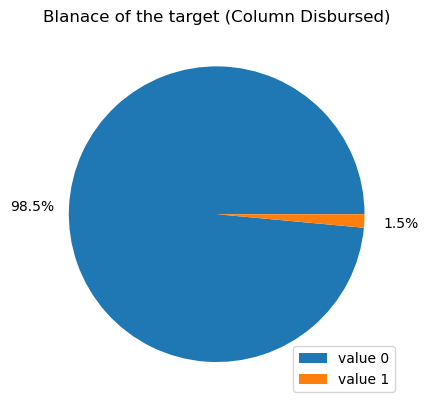

In [87]:
plt.pie(data_raw['Disbursed'].value_counts()/len(data_raw['Disbursed']), autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.6)

plt.title("Balnace of the target (Column Disbursed)")
plt.legend(['value 0', 'value 1'], loc=4)
plt.show()

In [88]:
target_0 = data_raw['Disbursed'][data_raw['Disbursed']==0].value_counts()
target_1 = data_raw['Disbursed'][data_raw['Disbursed']==1].value_counts()
print(f"value {target_0},\nvalue {target_1}")

value 0    85747
Name: Disbursed, dtype: int64,
value 1    1273
Name: Disbursed, dtype: int64


**conclusion** 

Database consists of 87020 entries where only 1.5% of target values are labeled as 1. That makes only 1273 entries of total 87020 entries. Our case is a classification problem with large class imbalance.


**2.3 Plotting histograms for numerical columns**

In [89]:
int_columns = ["Monthly_Income", "Loan_Amount_Applied", "Loan_Tenure_Applied", "Existing_EMI", 
               "Var5", "Loan_Amount_Submitted", "Loan_Tenure_Submitted", "Interest_Rate", "Processing_Fee", 
              "EMI_Loan_Submitted", "Var4"]

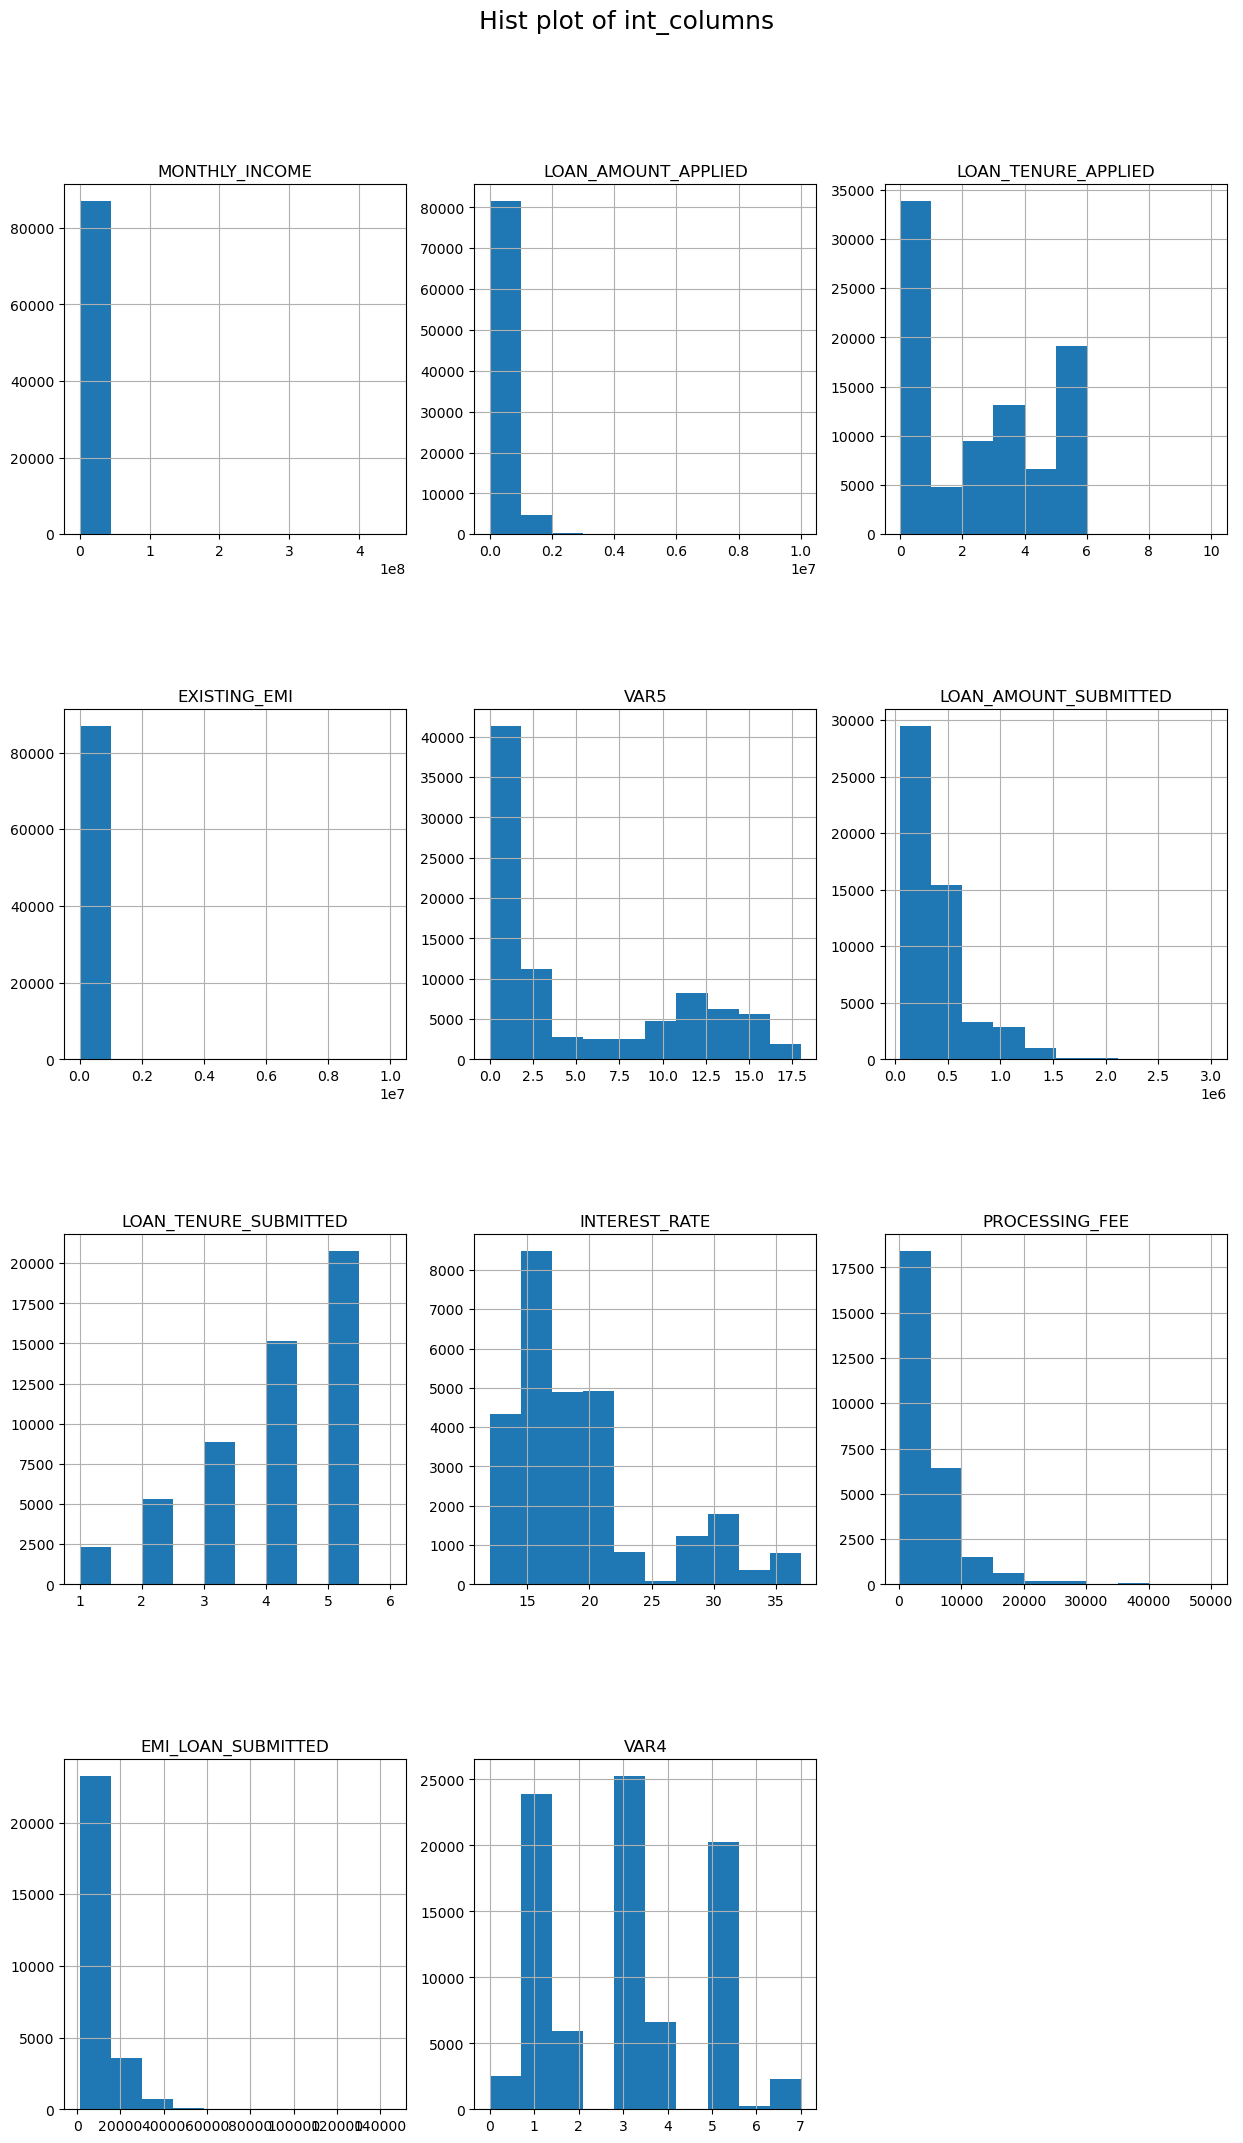

In [90]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 25))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Hist plot of int_columns", fontsize=18, y=0.95)


for col, ax in zip(int_columns, axs.ravel()):
    data_raw[col].hist(ax=ax)
    ax.set_title(col.upper())
    ax.set_xlabel("")
fig.delaxes(axs[-1,-1])
plt.show()

**conclusion** 

In following columns 'Monthly_Income', 'Loan_Amount_Applied', 'Existing_EMI', 'Loan_Amount_Submitted', 'Processing_Fee', 'EMI_Loan_Submitted' presents huge skewness. 

It is worthy to check log function of above columns

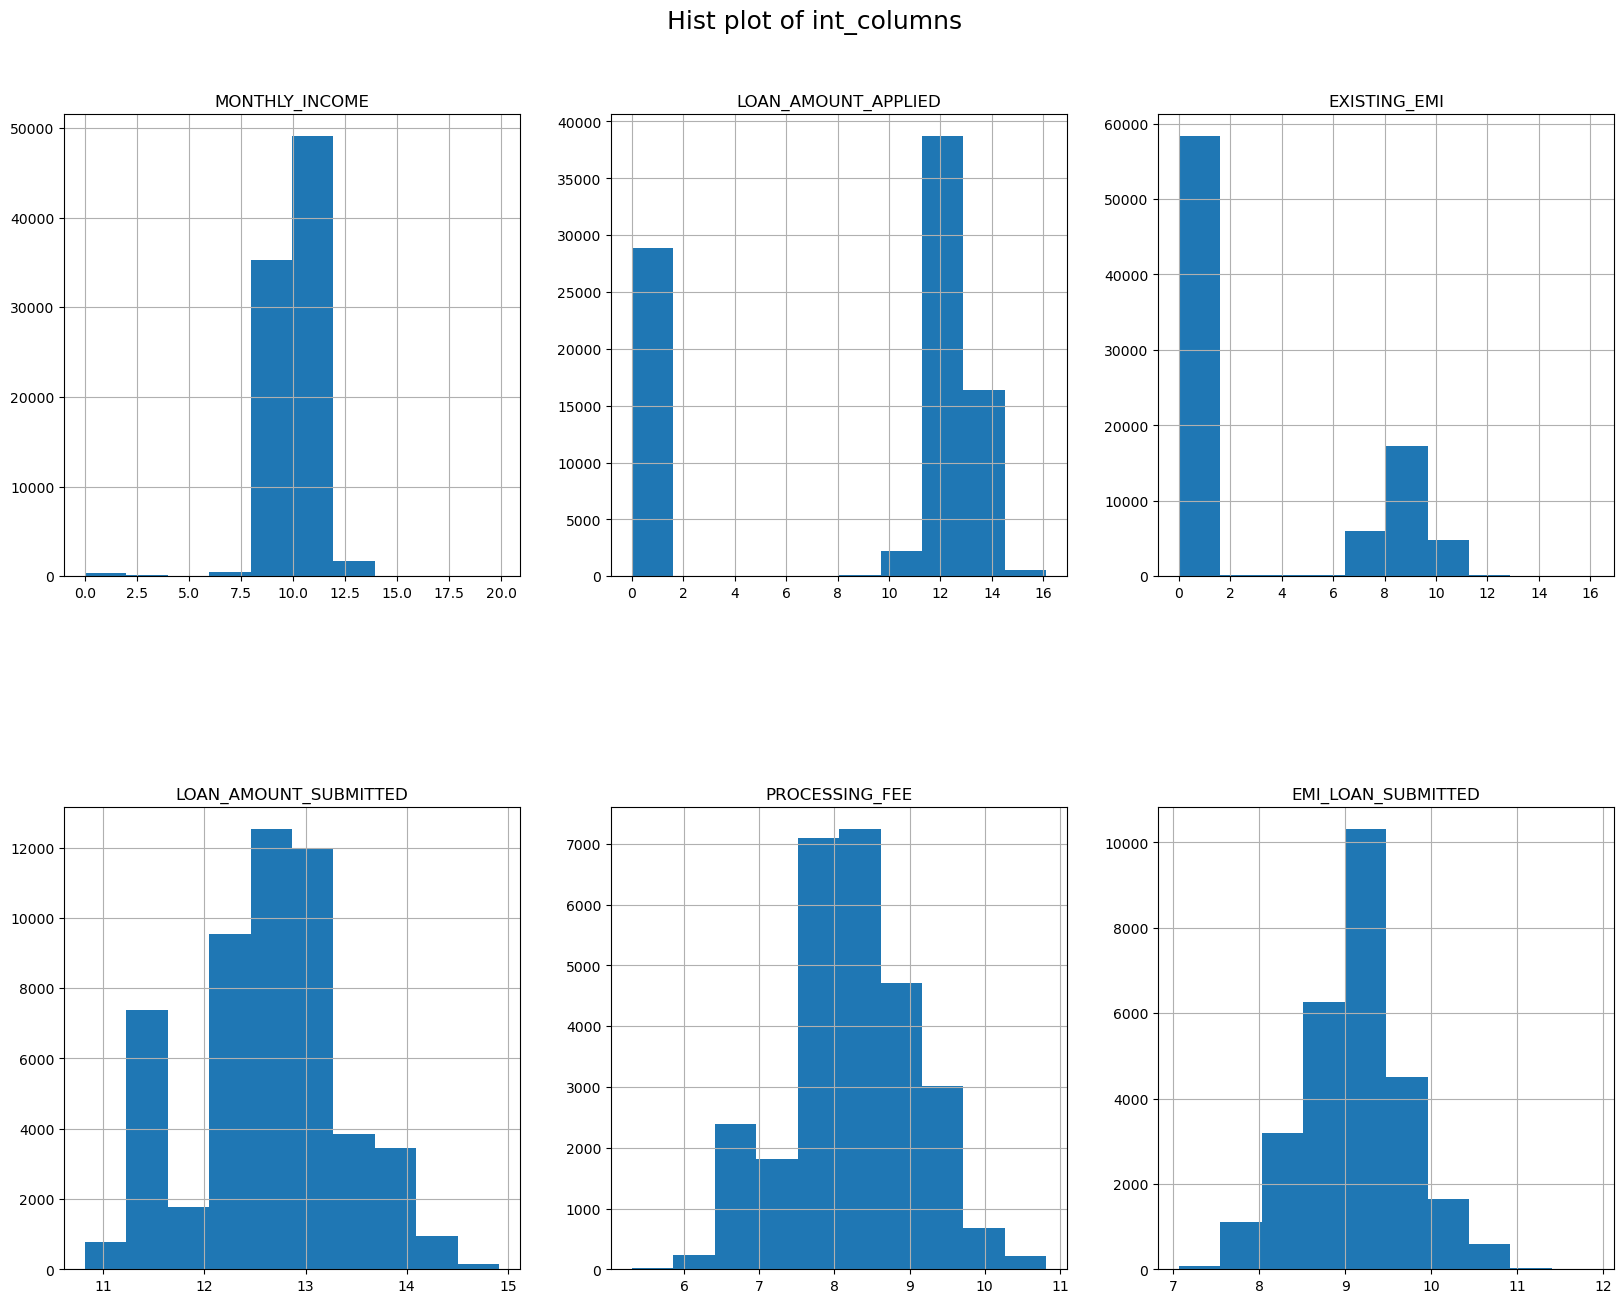

In [91]:
log_features_list = ['Monthly_Income', 'Loan_Amount_Applied', 'Existing_EMI', 
                     'Loan_Amount_Submitted', 'Processing_Fee', 'EMI_Loan_Submitted']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Hist plot of int_columns", fontsize=18, y=0.95)


for col, ax in zip(log_features_list, axs.ravel()):
    np.log1p(data_raw[col]).hist(ax=ax)
    ax.set_title(col.upper())
    ax.set_xlabel("")
plt.show()

**conclusion** 

Features 'Monthly_Income' and 'Loan_Tenure_Submitted  have a lot of outliers.


**2.4 Unique values in categorical features**

In [93]:
cat_features_data_raw = [col for col in list(data_raw.columns) if data_raw[col].dtypes == object  ]

In [94]:
num_of_unique = {'number of unique values': [len(data_raw[i].unique()) for i in cat_features_data_raw]}
num_of_unique_df = pd.DataFrame(num_of_unique, index=[cat_features_data_raw])
num_of_unique_df

,number of unique values
ID,87020
Gender,2
City,698
DOB,11345
Lead_Creation_Date,92
Employer_Name,43568
Salary_Account,58
Mobile_Verified,2
Var1,19
Filled_Form,2


**conclusion**

Lots of unique values in columns: City, Employer_Name, DOB, Lead_Creation_Date, Salary_Account.
Next steps to do:
1) Group cities by 3 categories : Big, Medium, Small
2) Any Value in Employer Name change to 1, otherwise 0
3) Any Value in Salary_Account change to 1, otherwise 0
4) combine DOB and Lead_Creation_Date to an Age of the person on lead  creation date


# 3 Data Preprocessing

In [95]:
data = data_raw.drop(['ID', 'Disbursed', 'LoggedIn'], axis=1)

**assignemnt of custom functions**

In [96]:
employer = data_preparation.EmployerDataPreparation()
salary = data_preparation.SalaryAccountDataPreparation(data)
city = data_preparation.CityDataPreparation(data)
age = data_preparation.AgeDataPreparation(data)
other = data_preparation.OtherSimpleEncoding(data)

**step 1** Grouping cities by 3 categories : Big, Medium, Small

* Cities with over 10 mln people: 'Delhi', 'Mumbai', 'Kolkata', 'Bengaluru', 'Chennai', 'Hyderabad'


* Cities with 2 - 10 mln people Ahmadabad', 'Surat', 'Pune', 'Jaipur', 'Lucknow', 'Kozhikode', 'Malappuram', 'Thrissur', 'Kochi', 'Kanpur',  'Indore', 'Nagpur', 'Coimbatore', 'Thiruvananthapuram', 'Patna', 'Bhopal', 'Agra', 'Vadodara', 'Kannur', 'Visakhapatnam', 'Nashik', 'Vijayawada' 


* Cities with less then 2 mln people: all other

source https://statisticstimes.com/demographics/country/india-cities-population.php


In [97]:
data['City'] = data['City'].apply(lambda x: city.big_medium_small_city_groupping(x))

**step 2** changing any Value in Employer Name  to 1, otherwise 0

In [98]:
data['Employer_Name'] = data['Employer_Name'].apply(lambda x: employer.zero_one_encoding_employer(x))

**step 3** changing any Value in Salary_Account to 1, otherwise 0

In [99]:
data['Salary_Account'] = data['Salary_Account'].apply(lambda x: salary.zero_one_encoding_salary_account(x)) 

**step 4** combinng DOB and Lead_Creation_Date to an Age of the person on lead creation date

In [100]:
data['Age'] = age.age_counter()

In [101]:
data = data.drop(['DOB', 'Lead_Creation_Date'], axis=1)

In [102]:
cat_features = [col for col in list(data.columns) if data[col].dtypes == object  ]
num_of_unique_after_4_steps = {'number of unique values': [len(data[i].unique()) for i in cat_features]}
num_of_unique_df = pd.DataFrame(num_of_unique_after_4_steps, index=[cat_features])

In [103]:
num_of_unique_df

,number of unique values
Gender,2
City,4
Mobile_Verified,2
Var1,19
Filled_Form,2
Device_Type,2
Var2,7
Source,30


**Redefining values in columns Gender,  Mobile_Verified, Filled_Form, Device_Type for binary column 0/1**

In [104]:
data['Mobile_Verified'] = other.mobile_verified_encoding() # 1 - Yes, 0 - No
data["Filled_Form"] = other.filled_form_encoding() # 1 - Yes, 0 - No
data["Gender"] = other.gender_encoding() # 1 - Female, 2- Male
data["Device_Type"] = other.device_encoding() # 1 - Mobile, 0 - Web-browser 

In [105]:
cat_features = [col for col in list(data.columns) if data[col].dtypes == object  ]
finnal_num_of_unique = {'number of unique values': [len(data[i].unique()) for i in cat_features]}
finnal_num_of_unique_df = pd.DataFrame(finnal_num_of_unique, index=[cat_features])
finnal_num_of_unique_df

,number of unique values
City,4
Var1,19
Var2,7
Source,30


In [106]:
data.head(5)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
0,1,big_city,20000,300000.0,5.0,0.0,1.0,1.0,0,0,HBXX,NaN,NaN,NaN,NaN,NaN,0,0,G,S122,1,37.0
1,0,big_city,35000,200000.0,2.0,0.0,1.0,1.0,1,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,0,0,G,S122,3,30.0
2,0,small_city,22500,600000.0,4.0,0.0,1.0,1.0,1,0,HBXX,450000.0,4.0,NaN,NaN,NaN,0,0,B,S143,1,34.0
3,0,small_city,35000,1000000.0,5.0,0.0,1.0,1.0,1,10,HBXX,920000.0,5.0,NaN,NaN,NaN,0,0,B,S143,3,27.0
4,0,big_city,100000,500000.0,2.0,25000.0,1.0,1.0,1,17,HBXX,500000.0,2.0,NaN,NaN,NaN,0,0,B,S134,3,31.0


# 4. Imputing missing values

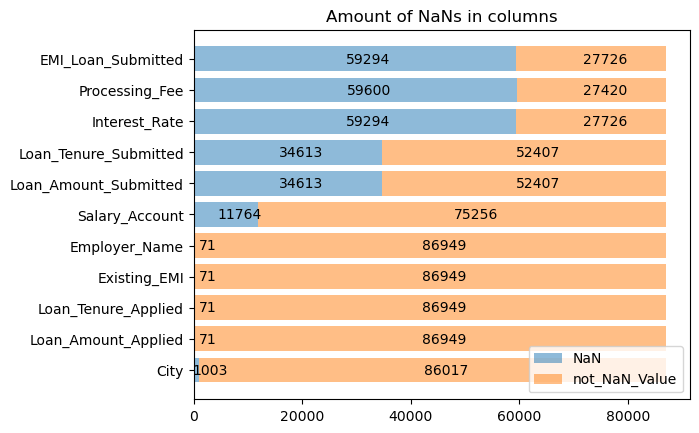

In [107]:
plotter.bar_chart_plotter(data)

**4.1 Loan Tenure and Loan Amount analysis**

Looking for relationship between Loan Tenure Applied/Loan Tenure Submitted and Loan Amount Applied/Loan Amount Submitted.

In [108]:
repeating_values = {'repeating value': [len(data_raw[data_raw["Loan_Tenure_Applied"] == data_raw["Loan_Tenure_Submitted"]]),
                                            len(data_raw[data_raw["Loan_Amount_Applied"] == data_raw["Loan_Amount_Submitted"]])],
                         
                        'NaN in Submitted': [data_raw["Loan_Tenure_Submitted"].isna().sum(), data_raw["Loan_Amount_Submitted"].isna().sum()]}
repeating_values_df = pd.DataFrame(repeating_values, index=['Tenure_Applied/Submitted', 'Amount_Applied/Submitted'])
repeating_values_df

,repeating value,NaN in Submitted
Tenure_Applied/Submitted,30455,34613
Amount_Applied/Submitted,26091,34613


**conclusion**

Analysing Amount and Tenure Submitted we can see a lot of missing values - 34613. On the other hand 30455 entries of Tenure Subbmitted value repeat in Tenure Applied. Similar situation is in Amount submitted. It is worthy to imput missing values in Tenure/Amount Submitted with value from Tenure/Amount Applied indead of imputing with median or mean




In [109]:
my_imputer.tenure_amount_imputer(data)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
0,1,big_city,20000,300000.0,5.0,0.0,1.0,1.0,0,0,HBXX,300000.0,5.0,NaN,NaN,NaN,0,0,G,S122,1,37.0
1,0,big_city,35000,200000.0,2.0,0.0,1.0,1.0,1,13,HBXA,200000.0,2.0,13.25,NaN,6762.90,0,0,G,S122,3,30.0
2,0,small_city,22500,600000.0,4.0,0.0,1.0,1.0,1,0,HBXX,450000.0,4.0,NaN,NaN,NaN,0,0,B,S143,1,34.0
3,0,small_city,35000,1000000.0,5.0,0.0,1.0,1.0,1,10,HBXX,920000.0,5.0,NaN,NaN,NaN,0,0,B,S143,3,27.0
4,0,big_city,100000,500000.0,2.0,25000.0,1.0,1.0,1,17,HBXX,500000.0,2.0,NaN,NaN,NaN,0,0,B,S134,3,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,1,small_city,71901,1000000.0,5.0,14500.0,1.0,1.0,0,9,HBXX,1000000.0,5.0,NaN,NaN,NaN,0,0,G,S122,3,46.0
87016,1,medium_city,16000,0.0,0.0,0.0,1.0,1.0,1,1,HBXB,240000.0,4.0,35.50,4800.0,9425.76,1,1,G,S122,5,25.0
87017,0,big_city,118000,0.0,0.0,0.0,1.0,1.0,1,8,HBXX,1200000.0,4.0,NaN,NaN,NaN,0,1,G,S122,3,44.0
87018,0,big_city,98930,800000.0,5.0,13660.0,1.0,1.0,1,18,HBXX,800000.0,5.0,NaN,NaN,NaN,0,0,G,S122,3,38.0


**4.2 imputing City and Salary** changing NaN for 0

In [110]:
my_imputer.city_salary_imputer(data)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
0,1,big_city,20000,300000.0,5.0,0.0,1.0,1.0,0,0,HBXX,300000.0,5.0,NaN,NaN,NaN,0,0,G,S122,1,37.0
1,0,big_city,35000,200000.0,2.0,0.0,1.0,1.0,1,13,HBXA,200000.0,2.0,13.25,NaN,6762.90,0,0,G,S122,3,30.0
2,0,small_city,22500,600000.0,4.0,0.0,1.0,1.0,1,0,HBXX,450000.0,4.0,NaN,NaN,NaN,0,0,B,S143,1,34.0
3,0,small_city,35000,1000000.0,5.0,0.0,1.0,1.0,1,10,HBXX,920000.0,5.0,NaN,NaN,NaN,0,0,B,S143,3,27.0
4,0,big_city,100000,500000.0,2.0,25000.0,1.0,1.0,1,17,HBXX,500000.0,2.0,NaN,NaN,NaN,0,0,B,S134,3,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,1,small_city,71901,1000000.0,5.0,14500.0,1.0,1.0,0,9,HBXX,1000000.0,5.0,NaN,NaN,NaN,0,0,G,S122,3,46.0
87016,1,medium_city,16000,0.0,0.0,0.0,1.0,1.0,1,1,HBXB,240000.0,4.0,35.50,4800.0,9425.76,1,1,G,S122,5,25.0
87017,0,big_city,118000,0.0,0.0,0.0,1.0,1.0,1,8,HBXX,1200000.0,4.0,NaN,NaN,NaN,0,1,G,S122,3,44.0
87018,0,big_city,98930,800000.0,5.0,13660.0,1.0,1.0,1,18,HBXX,800000.0,5.0,NaN,NaN,NaN,0,0,G,S122,3,38.0


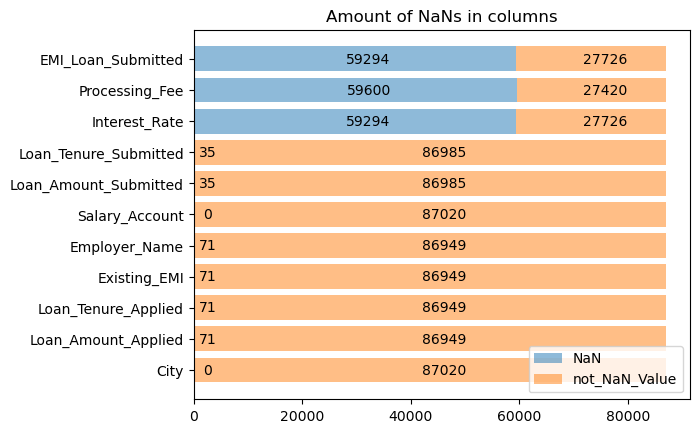

In [111]:
plotter.bar_chart_plotter(data)

# 5. Defining X and y

In [112]:
X = data
y = data_raw['Disbursed']

# 6. Defining important variables


In [113]:
cat_features = [col for col in list(X.columns) if X[col].dtypes == object  ]

In [114]:
num_features = [col for col in list(X.columns) if X[col].dtypes != object  ]

In [115]:
all_columns = num_features + cat_features

In [116]:
log_features_list = ['Monthly_Income', 'Loan_Amount_Applied', 'Existing_EMI', 
                     'Loan_Amount_Submitted', 'Processing_Fee', 'EMI_Loan_Submitted']

In [117]:
log_transformer = FunctionTransformer(np.log1p)

# 7. Base test

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [119]:
num_pipe = Pipeline([
    ("log_transformer", ColumnTransformer([
        ("log", log_transformer, log_features_list)], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer())
])

cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(drop = "first", handle_unknown = "ignore"))
])


preprocessor = ColumnTransformer(transformers=[
    ("numeric", num_pipe, num_features),
    ("categorical", cat_pipe, cat_features)
])


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", 'passthrough')
], memory='cache')

cv_schema = KFold(5, shuffle=True) 

param_grid = [
    
    {
    'model':[LogisticRegression(n_jobs  = -1, max_iter = 10000)],
    "model__class_weight": [{0:1, 1:50}, {0:1, 1:80}, {0:1, 1:100}],
    "model__C": [0.01, 0.1, 1, 10, 100, 1000]
        
    },
     {
     "model": [RandomForestClassifier()],
     "model__n_estimators": [100],
     "model__min_samples_leaf": [50, 80, 100],
     "model__max_depth": [None, 5, 10, 15, 20, 30, 40],
     "model__max_samples": [0.5, 0.8, 1],
     "model__class_weight": [{0:1, 1:50}, {0:1, 1:80}, {0:1, 1:100}]
     }
#     {
#     "model": [KNeighborsClassifier()],
#     "model__n_neighbors": [2, 7, 9, 15],
#     "model__p": [1, 2],
#     "model__weights": ['uniform', 'distance']
#     }
]


optimizer_base = GridSearchCV(pipeline,
                         param_grid, 
                         scoring="roc_auc", 
                         cv=cv_schema, 
                         n_jobs=-1)

In [120]:
optimizer_base.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(memory='cache',
                                steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('log_transformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('log',
                                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                           ['Monthly_Income',
                                                                                                                            'Loan_Amount_Applied',
                                                                                                                            'Exist...
                          'model__class_weight': [{0: 1, 1: 50}, {0: 1, 1: 80},
                                                  {0: 1, 1: 100}]},
                         {'model': [RandomForestClassifier(class_weight={0: 1,
                                                                         1: 50},
                                                           max_samples=0.8,
                                                           min_samples_leaf=50)],
                          'model__class_weight': [{0: 1, 1: 50}, {0: 1, 1: 80},
                                                  {0: 1, 1: 100}],
                          'model__max_depth': [None, 5, 10, 15, 20, 30, 40],
                          'model__max_samples': [0.5, 0.8, 1],
                          'model__min_samples_leaf': [50, 80, 100],
                          'model__n_estimators': [100]}],
             scoring='roc_auc')

In [121]:
optimizer_base.best_params_

{'model': RandomForestClassifier(class_weight={0: 1, 1: 50}, max_samples=0.8,
                        min_samples_leaf=50),
 'model__class_weight': {0: 1, 1: 50},
 'model__max_depth': None,
 'model__max_samples': 0.8,
 'model__min_samples_leaf': 50,
 'model__n_estimators': 100}

In [122]:
y_pred = optimizer_base.best_estimator_.predict(X_test)

C:\Users\arkur\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [123]:
results = []

In [124]:
y_proba, roc_auc_test, results_df = results_func.results_printer(X_test, y_test, optimizer_base, results)

C:\Users\arkur\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\arkur\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [125]:
results_df

,best clf name,Test F1,Test Recall,Test Precision,Test ROC AUC
0,RandomForestClassifier,0.109768,0.576142,0.060663,0.827641


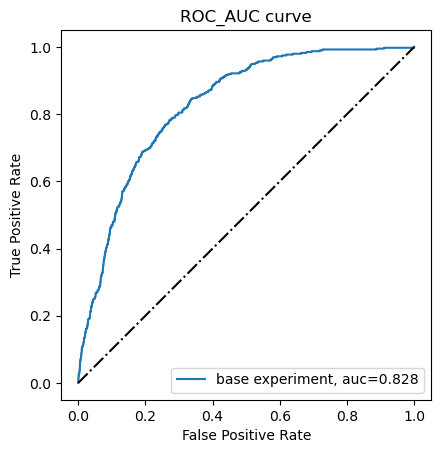

In [126]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba)
plt.plot(fpr,tpr,label="base experiment, auc="+str(roc_auc_test.round(3)))

plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),linestyle='-.',color='k')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC curve")

plt.legend(loc=4)
plt.show()

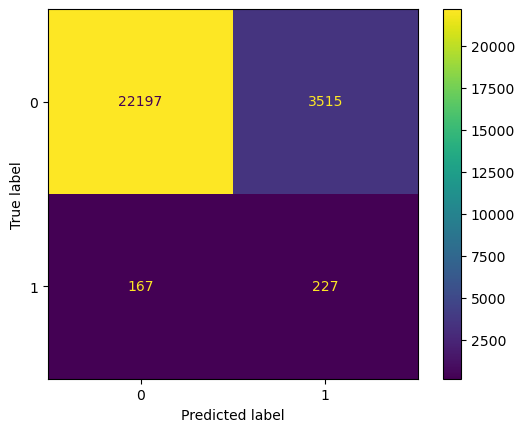

In [127]:
matrix_base = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_base, display_labels=None) 
disp.plot() 
plt.show()

# 8. Balancing Class Experiment - SMOTE

In [128]:
data.head()

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
0,1,big_city,20000,300000.0,5.0,0.0,1.0,1.0,0,0,HBXX,300000.0,5.0,NaN,NaN,NaN,0,0,G,S122,1,37.0
1,0,big_city,35000,200000.0,2.0,0.0,1.0,1.0,1,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,0,0,G,S122,3,30.0
2,0,small_city,22500,600000.0,4.0,0.0,1.0,1.0,1,0,HBXX,450000.0,4.0,NaN,NaN,NaN,0,0,B,S143,1,34.0
3,0,small_city,35000,1000000.0,5.0,0.0,1.0,1.0,1,10,HBXX,920000.0,5.0,NaN,NaN,NaN,0,0,B,S143,3,27.0
4,0,big_city,100000,500000.0,2.0,25000.0,1.0,1.0,1,17,HBXX,500000.0,2.0,NaN,NaN,NaN,0,0,B,S134,3,31.0


In [129]:
sm = SMOTE()

In [130]:
num_pipe = Pipeline([
    ("log_transformer", ColumnTransformer([
        ("log", log_transformer, log_features_list)], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer())
])

cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(drop = "first", handle_unknown = "ignore"))
])


preprocessor = ColumnTransformer(transformers=[
    ("numeric", num_pipe, num_features),
    ("categorical", cat_pipe, cat_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('smote', sm),
    ("model", 'passthrough')
], memory='cache')

cv_schema = KFold(5, shuffle=True) # dane są duże i dla 5 będzie szybciej

param_grid = [
    {
    'model':[LogisticRegression(n_jobs  = -1, max_iter = 10000)],
    "model__class_weight": [{0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}],
    "model__C": [0.01, 0.1, 1, 10, 100, 1000]
        
    },
     {
     "model": [RandomForestClassifier()],
     "model__n_estimators": [50],
     "model__min_samples_leaf": [50, 80, 100, 150, 200],
     "model__max_depth": [None, 5, 10, 15, 20, 30, 40],
     "model__max_samples": [0.5, 0.8, 1],
     "model__class_weight": [{0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}]
     }
#     {
#     "model": [KNeighborsClassifier()],
#     "model__n_neighbors": [2, 7, 9, 15],
#     "model__p": [1, 2],
#     "model__weights": ['uniform', 'distance']
#     }
]


optimizer_smote = GridSearchCV(pipeline,
                         param_grid, 
                         scoring="roc_auc", 
                         cv=cv_schema, 
                         n_jobs=-1)

In [131]:
optimizer_smote.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(memory='cache',
                                steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('log_transformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('log',
                                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                           ['Monthly_Income',
                                                                                                                            'Loan_Amount_Applied',
                                                                                                                            'Exist...
                         {'model': [RandomForestClassifier(class_weight={0: 1,
                                                                         1: 10},
                                                           max_depth=40,
                                                           max_samples=0.5,
                                                           min_samples_leaf=100,
                                                           n_estimators=50)],
                          'model__class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20},
                                                  {0: 1, 1: 30}],
                          'model__max_depth': [None, 5, 10, 15, 20, 30, 40],
                          'model__max_samples': [0.5, 0.8, 1],
                          'model__min_samples_leaf': [50, 80, 100, 150, 200],
                          'model__n_estimators': [50]}],
             scoring='roc_auc')

In [132]:
optimizer_smote.best_params_

{'model': RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=40,
                        max_samples=0.5, min_samples_leaf=100, n_estimators=50),
 'model__class_weight': {0: 1, 1: 10},
 'model__max_depth': 40,
 'model__max_samples': 0.5,
 'model__min_samples_leaf': 100,
 'model__n_estimators': 50}

In [133]:
y_pred = optimizer_smote.best_estimator_.predict(X_test)

C:\Users\arkur\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [134]:
y_proba, roc_auc_test, results_df = results_func.results_printer(X_test, y_test, optimizer_smote, results)

C:\Users\arkur\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\arkur\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [135]:
results_df

,best clf name,Test F1,Test Recall,Test Precision,Test ROC AUC
0,RandomForestClassifier,0.109768,0.576142,0.060663,0.827641
1,RandomForestClassifier,0.055212,0.941624,0.028440,0.819069


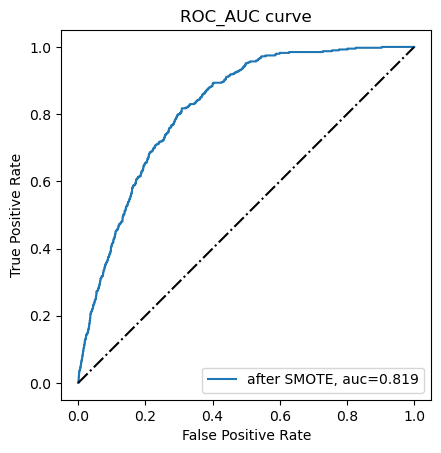

In [136]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba)
plt.plot(fpr,tpr,label="after SMOTE, auc="+str(roc_auc_test.round(3)))

plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),linestyle='-.',color='k')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC curve")

plt.legend(loc=4)
plt.show()

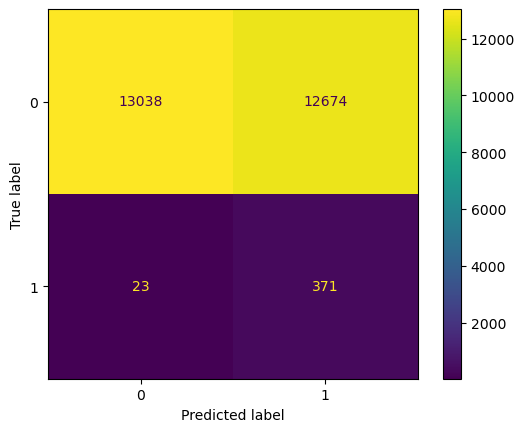

In [137]:
matrix_smote = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_smote, display_labels=None) 
disp.plot() 
plt.show()

# 9. Final conclusion

<br>* Data Exploratory was the biggest part of the work. Many missing values, huge differentiation in some features, very large imbalances between classes. 


<br>* Two test were conducted: The first one called BASE and another one with Balancing Class Experiment. Looking only at ROC_AUC scores final results are similar. But there is an important difference which is visable in the confusion matrix. After SMOTE implemenation model can much easier find True values: 371 1-labeled entries compering with 227 1-labaled entries in base experiment.


<br>* Only two models were considered: Logistic Regression and Random Forest Classifier. KNN Classifier were only tested with default parameters due to quite big databse. ANother models worthy to implement into Pipelines are: LGBMClassifier, GBClassifier.


<br>* Also It may be interesting to display, and compare results of all models included in pipelines. Not only models with best_params.